# Positionless Basketball

-----------

This project has several goals:

* Identify features to use in PCA algorithm
* Decompose data with PCA
* Identify similar observations with K-Means clustering
* Measure differences between groups (at low- and high-dimensional spaces)

In [1]:
# Imports
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
warnings.filterwarnings('ignore')

# Define custom palette to use for visualization
sns.set_style('white')
my_palette = ['#26547C', '#EF476F', '#FFD166', '#06D6A0', '#2D1E2F']
sns.color_palette(my_palette)

[(0.14901960784313725, 0.32941176470588235, 0.48627450980392156),
 (0.9372549019607843, 0.2784313725490196, 0.43529411764705883),
 (1.0, 0.8196078431372549, 0.4),
 (0.023529411764705882, 0.8392156862745098, 0.6274509803921569),
 (0.17647058823529413, 0.11764705882352941, 0.1843137254901961)]

--------

## Data Cleaning

In this section we'll read in the NBA data we scraped, clean it up, and identify any irregularities or multicollinearity issues.

In [2]:
# Read in data from 2020-2021 NBA season
nba = pd.read_csv('./nba-stats-2021.csv').iloc[:, 2:]

# Isolate categorical variables (Name, Team, Position)
positions_only = nba.iloc[:, :4]

# Create an aggregate row per player (for players that were traded in-season)
nba = nba.groupby('Player').mean().sort_values(by='PTS', ascending=False).reset_index()

nba.head()

,Player,Age_x,G_x,GS,MP_x,FG,FGA,FG%,3P,3PA,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,Stephen Curry,32.0,63.0,63.0,34.2,10.4,21.7,0.482,5.3,12.7,...,12.2,34.8,6.5,2.5,9.0,0.201,8.3,0.4,8.7,5.8
1,Bradley Beal,27.0,60.0,60.0,35.8,11.2,23.0,0.485,2.2,6.2,...,10.6,34.1,4.2,1.7,5.9,0.132,4.8,-1.4,3.4,2.9
2,Damian Lillard,30.0,67.0,67.0,35.8,9.0,19.9,0.451,4.1,10.5,...,11.6,31.4,9.6,0.8,10.4,0.209,7.5,-1.3,6.3,5.0
3,Joel Embiid,26.0,51.0,51.0,31.1,9.0,17.6,0.513,1.1,3.0,...,12.2,35.3,5.6,3.2,8.8,0.266,6.3,1.2,7.5,3.8
4,Giannis Antetokounmpo,26.0,61.0,61.0,33.0,10.3,18.0,0.569,1.1,3.6,...,13.2,32.5,6.9,3.3,10.2,0.244,6.2,2.8,9.0,5.6


In [3]:
# Clean up extra rows in positions_only dataframe
po = positions_only[positions_only['Tm'] != 'TOT'].groupby('Player').first().reset_index()

# Merge with nba dataframe
nba = nba.merge(po, on='Player', how='left').drop(columns=['Age_x_y'])

# Use list comprehension to clean up extra characters
nba.columns = [x.split('_')[0] for x in nba.columns]

nba.head()

,Player,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Pos,Tm
0,Stephen Curry,32.0,63.0,63.0,34.2,10.4,21.7,0.482,5.3,12.7,...,6.5,2.5,9.0,0.201,8.3,0.4,8.7,5.8,PG,GSW
1,Bradley Beal,27.0,60.0,60.0,35.8,11.2,23.0,0.485,2.2,6.2,...,4.2,1.7,5.9,0.132,4.8,-1.4,3.4,2.9,SG,WAS
2,Damian Lillard,30.0,67.0,67.0,35.8,9.0,19.9,0.451,4.1,10.5,...,9.6,0.8,10.4,0.209,7.5,-1.3,6.3,5.0,PG,POR
3,Joel Embiid,26.0,51.0,51.0,31.1,9.0,17.6,0.513,1.1,3.0,...,5.6,3.2,8.8,0.266,6.3,1.2,7.5,3.8,C,PHI
4,Giannis Antetokounmpo,26.0,61.0,61.0,33.0,10.3,18.0,0.569,1.1,3.6,...,6.9,3.3,10.2,0.244,6.2,2.8,9.0,5.6,PF,MIL


We have a clean dataset with tidy columns!

Let's reduce some potentital noise by filtering out players that don't see the floor very often

In [4]:
# Define 10th percentile for minutes played
cutoff = np.quantile(nba['MP'], 0.10)

# Remove players < 10th percentile of minutes played, hopefully reduce noise
nba = nba[nba['MP'] >= 6.58].reset_index(drop=True)

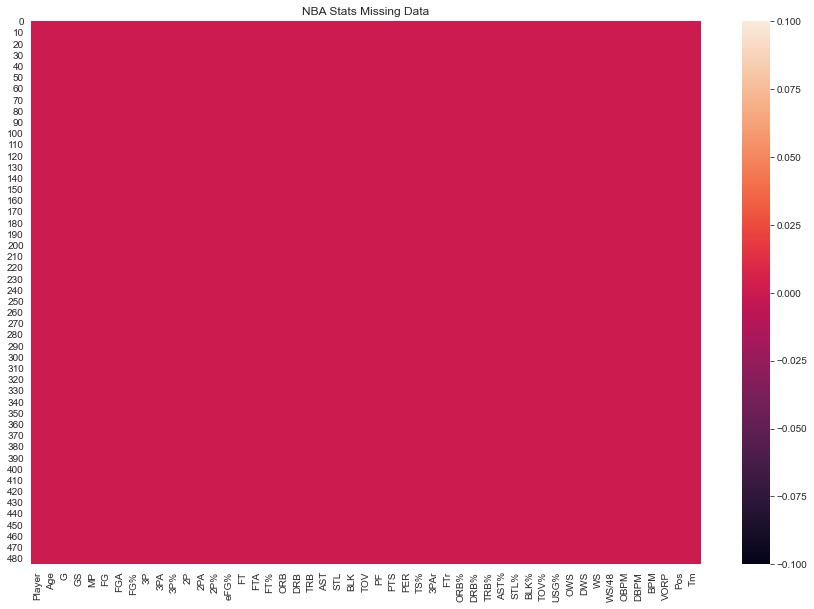

In [5]:
# Plot missing data
plt.figure(figsize=(15,10))
sns.heatmap(nba.isnull())
plt.title('NBA Stats Missing Data')
plt.show()

With no missing data to report, we can keep moving forward.

We want to plot any variables that are exceptionally collinear - that way we can remove them prior to clustering, to boost our signal a bit. First, we'll isolate the quantitative variables in this dataset

In [6]:
# Isolate quantitative features
quant_only = nba.select_dtypes(include=np.number)

quant_only.head()

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,32.0,63.0,63.0,34.2,10.4,21.7,0.482,5.3,12.7,0.421,...,12.2,34.8,6.5,2.5,9.0,0.201,8.3,0.4,8.7,5.8
1,27.0,60.0,60.0,35.8,11.2,23.0,0.485,2.2,6.2,0.349,...,10.6,34.1,4.2,1.7,5.9,0.132,4.8,-1.4,3.4,2.9
2,30.0,67.0,67.0,35.8,9.0,19.9,0.451,4.1,10.5,0.391,...,11.6,31.4,9.6,0.8,10.4,0.209,7.5,-1.3,6.3,5.0
3,26.0,51.0,51.0,31.1,9.0,17.6,0.513,1.1,3.0,0.377,...,12.2,35.3,5.6,3.2,8.8,0.266,6.3,1.2,7.5,3.8
4,26.0,61.0,61.0,33.0,10.3,18.0,0.569,1.1,3.6,0.303,...,13.2,32.5,6.9,3.3,10.2,0.244,6.2,2.8,9.0,5.6


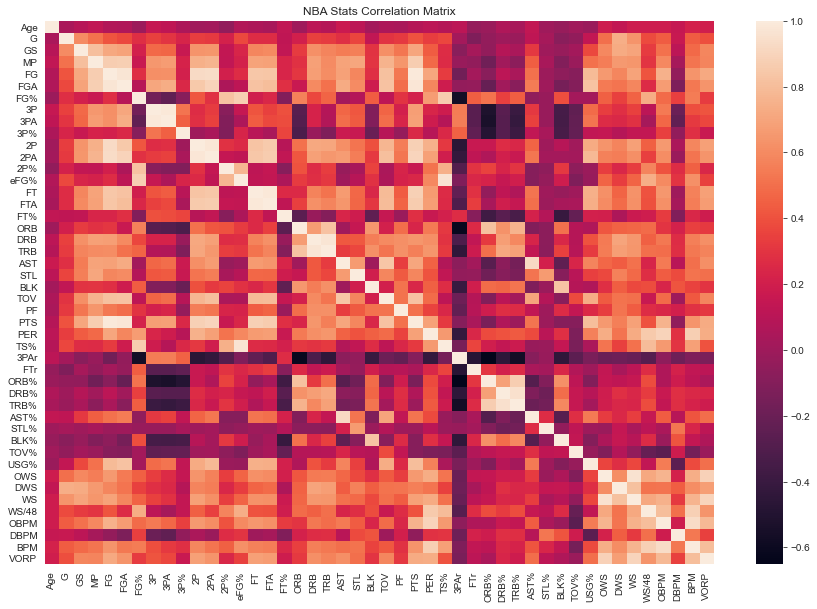

In [7]:
plt.figure(figsize=(15,10))
sns.heatmap(quant_only.corr())
plt.title('NBA Stats Correlation Matrix')
plt.show()

Predictably, a few variables appear to be very collinear (e.g., field goals made and field goals attempted). We can drop these without issue

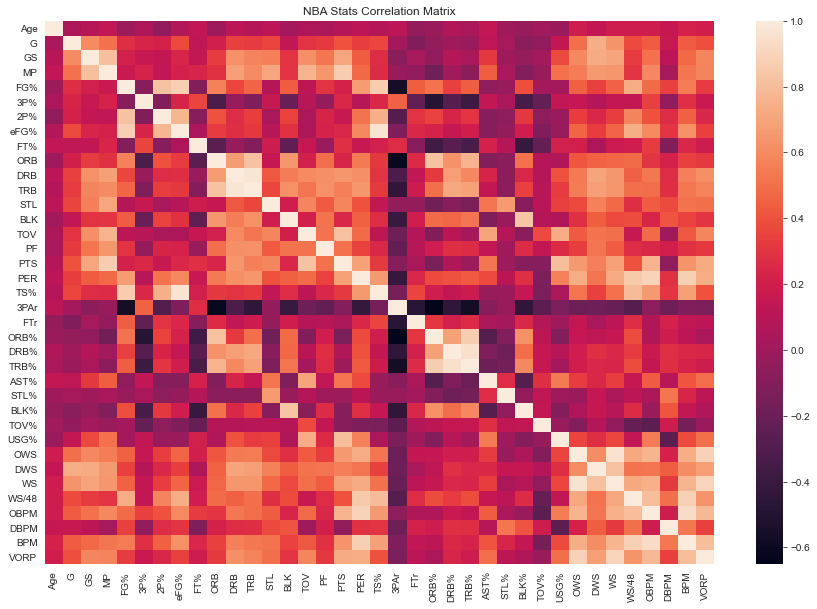

In [8]:
# Highly correlated columns
raw_stats_to_drop = ['FG', 'FGA', '2P', '2PA', '3P', '3PA', 'FT', 'FTA', 'AST']

# Drop factors above
quant_only = quant_only.drop(columns=raw_stats_to_drop)

# Plot a new correlation matrix
plt.figure(figsize=(15,10))
sns.heatmap(quant_only.corr())
plt.title('NBA Stats Correlation Matrix')
plt.show()

-----------

## Decomposition

In this section, we'll scale all of our quantitative data, decompose it using PCA, and identify similar observations (i.e., players)

In [9]:
# Imports
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

quant_only.head()

,Age,G,GS,MP,FG%,3P%,2P%,eFG%,FT%,ORB,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,32.0,63.0,63.0,34.2,0.482,0.421,0.569,0.605,0.916,0.5,...,12.2,34.8,6.5,2.5,9.0,0.201,8.3,0.4,8.7,5.8
1,27.0,60.0,60.0,35.8,0.485,0.349,0.535,0.532,0.889,1.2,...,10.6,34.1,4.2,1.7,5.9,0.132,4.8,-1.4,3.4,2.9
2,30.0,67.0,67.0,35.8,0.451,0.391,0.519,0.554,0.928,0.5,...,11.6,31.4,9.6,0.8,10.4,0.209,7.5,-1.3,6.3,5.0
3,26.0,51.0,51.0,31.1,0.513,0.377,0.541,0.545,0.859,2.2,...,12.2,35.3,5.6,3.2,8.8,0.266,6.3,1.2,7.5,3.8
4,26.0,61.0,61.0,33.0,0.569,0.303,0.636,0.600,0.685,1.6,...,13.2,32.5,6.9,3.3,10.2,0.244,6.2,2.8,9.0,5.6


In [10]:
# Instantiate and fit StandardScaler object to data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(quant_only)

scaled_data

array([[ 1.51095706,  0.98498672,  1.80035694, ...,  0.39144834,
         2.927264  ,  4.6922583 ],
       [ 0.29317077,  0.83259538,  1.6705539 , ..., -1.06398415,
         1.34564618,  2.10696406],
       [ 1.02384254,  1.18817519,  1.97342767, ..., -0.98312679,
         2.2110597 ,  3.97907368],
       ...,
       [-1.41173003, -1.70726038, -0.92550698, ..., -0.57883999,
        -2.62331927, -0.65662634],
       [-0.19394374, -1.96124596, -0.92550698, ...,  2.97888389,
         0.59960004, -0.47833018],
       [ 2.24162883, -1.60566615, -0.92550698, ...,  0.79573515,
        -0.71344116, -0.47833018]])

In [11]:
# Instantiate PCA object with two components (for visualization purposes)
pca = PCA(n_components = 2)

# Fit to data
low_dimensional_data = pca.fit_transform(scaled_data)

# Check shape
low_dimensional_data.shape

(486, 2)

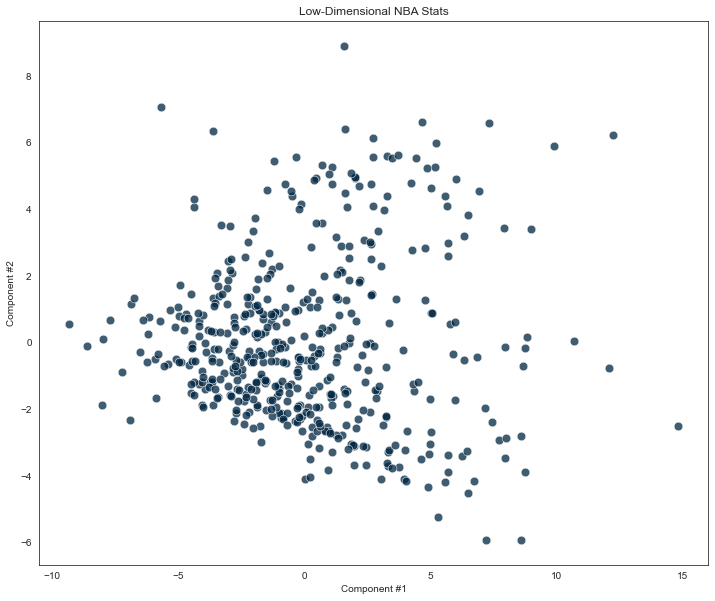

In [12]:
plt.figure(figsize=(12, 10))

sns.scatterplot(low_dimensional_data[:,0], low_dimensional_data[:,1], 
                alpha=0.75, color='#002642', s=75)

plt.title('Low-Dimensional NBA Stats')
plt.xlabel('Component #1')
plt.ylabel('Component #2')
plt.show()

We see spread on both axes, which suggests that each component is explaining some of the total variance

Next we'll want to identify the optimal number of clusters for our dataset using the elbow method

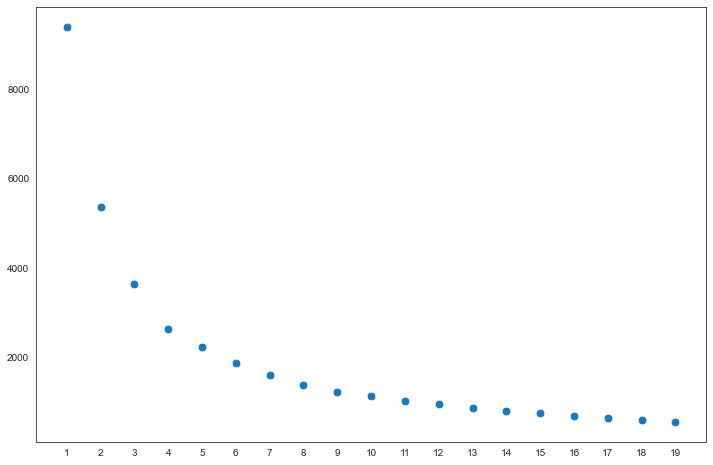

In [13]:
test_range = range(1,20)
sum_of_squares = []

for val in test_range:
    
    # Instantiate and fit n value to KMeans object
    temp = KMeans(n_clusters = val)
    temp.fit(low_dimensional_data)
    
    # Add inertia to container
    sum_of_squares.append(temp.inertia_)
    
# Plot results
plt.figure(figsize=(12,8))
sns.scatterplot(test_range, sum_of_squares, s=75)
plt.xticks(test_range)
plt.show()

We see a change in model fit around **k = 5**, so we'll opt for 5 unique clusters in this analysis

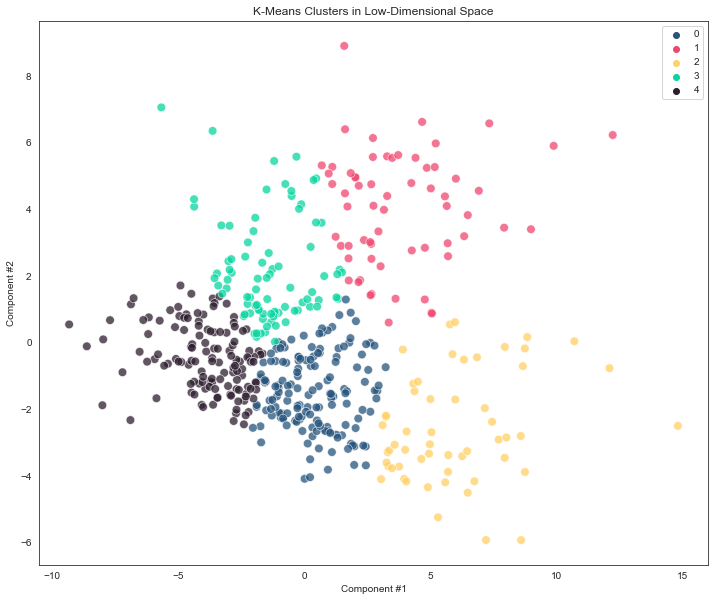

In [14]:
# Instantiate and fit KMeans object to data
model = KMeans(n_clusters=5, random_state=101)
model.fit(low_dimensional_data)

# Predict based on the KMeans object
predicted_values = model.predict(low_dimensional_data)

# Plot results
plt.figure(figsize=(12, 10))
sns.scatterplot(low_dimensional_data[:, 0], low_dimensional_data[:, 1],
                hue = model.labels_, alpha=0.75, s=75, palette=my_palette)
plt.title('K-Means Clusters in Low-Dimensional Space')
plt.xlabel('Component #1')
plt.ylabel('Component #2')
plt.show()

-------

## On the Court

In this section we'll project our predicted cluster values up to the high-dimensional dataset to see how clusters relate to performance on the court

In [15]:
# Project cluster labels to the high-dimensional data
nba['cluster'] = predicted_values

nba

,Player,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Pos,Tm,cluster
0,Stephen Curry,32.0,63.0,63.0,34.2,10.4,21.7,0.482,5.3,12.7,...,2.5,9.0,0.201,8.3,0.4,8.7,5.8,PG,GSW,2
1,Bradley Beal,27.0,60.0,60.0,35.8,11.2,23.0,0.485,2.2,6.2,...,1.7,5.9,0.132,4.8,-1.4,3.4,2.9,SG,WAS,2
2,Damian Lillard,30.0,67.0,67.0,35.8,9.0,19.9,0.451,4.1,10.5,...,0.8,10.4,0.209,7.5,-1.3,6.3,5.0,PG,POR,2
3,Joel Embiid,26.0,51.0,51.0,31.1,9.0,17.6,0.513,1.1,3.0,...,3.2,8.8,0.266,6.3,1.2,7.5,3.8,C,PHI,2
4,Giannis Antetokounmpo,26.0,61.0,61.0,33.0,10.3,18.0,0.569,1.1,3.6,...,3.3,10.2,0.244,6.2,2.8,9.0,5.6,PF,MIL,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,Kris Dunn,26.0,4.0,0.0,11.3,0.3,3.0,0.083,0.0,0.5,...,0.1,-0.2,-0.202,-13.7,-0.1,-13.7,-0.1,PG,ATL,4
482,Andre Roberson,29.0,5.0,0.0,12.6,0.4,2.8,0.143,0.2,1.6,...,0.1,-0.1,-0.043,-5.2,-0.9,-6.1,-0.1,SG,BRK,4
483,Karim Mané,20.0,10.0,0.0,8.8,0.3,1.3,0.231,0.1,0.2,...,0.0,-0.1,-0.045,-9.1,-0.8,-9.9,-0.2,PG,ORL,4
484,Patrick McCaw,25.0,5.0,0.0,6.6,0.2,0.2,1.000,0.0,0.0,...,0.0,0.1,0.209,-2.7,3.6,0.9,0.0,SF,TOR,1


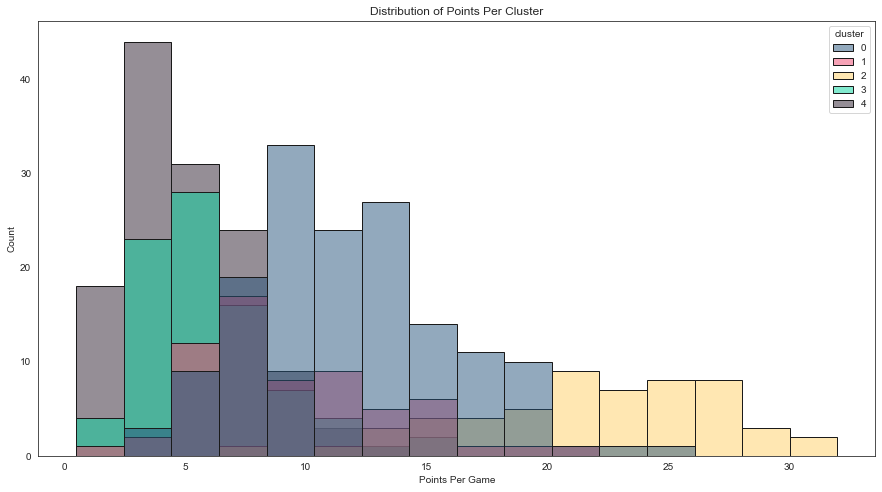

In [16]:
plt.figure(figsize=(15, 8))

sns.histplot(data=nba, x='PTS', hue='cluster', palette=my_palette,
            edgecolor=".1", linewidth=1)

plt.xlabel('Points Per Game')
plt.title('Distribution of Points Per Cluster')
plt.show()

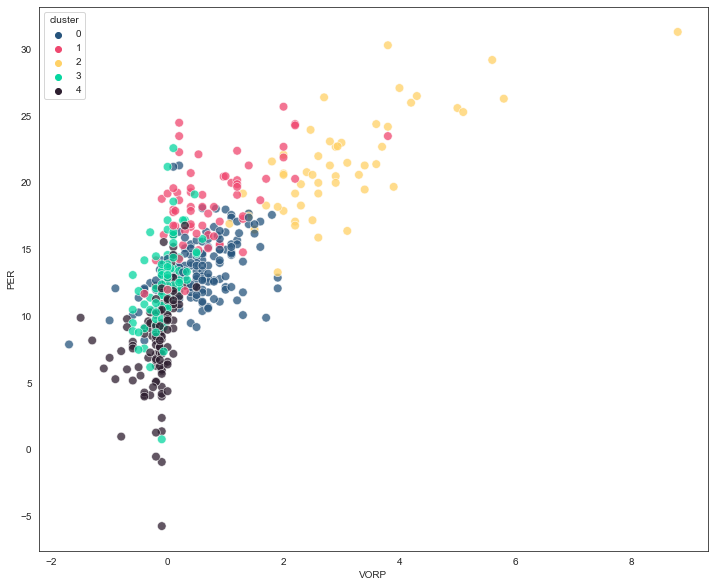

In [17]:
plt.figure(figsize=(12,10))
sns.scatterplot(data=nba, x="VORP", y="PER", 
                hue="cluster", palette=my_palette, s=75, alpha=0.75)
plt.show()

Clearly **Cluster 2** represents the best players in the league - players in this cluster score more points, are more efficient, and less replaceable. Let's see how each cluster breaks down in terms of their positional makeup (the crux of this project, in fact!)

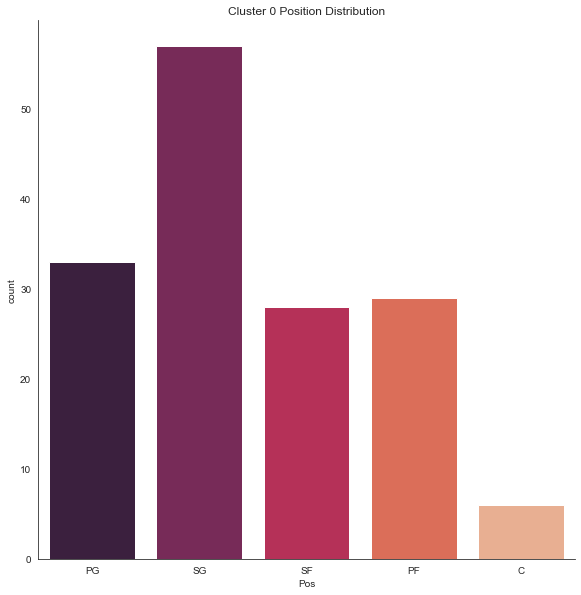

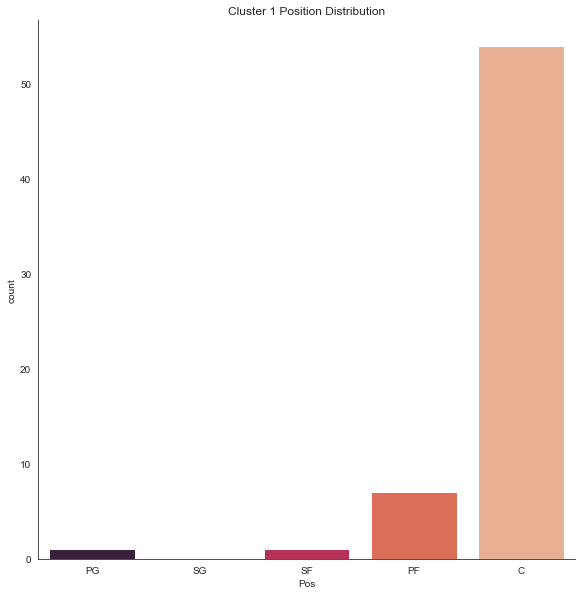

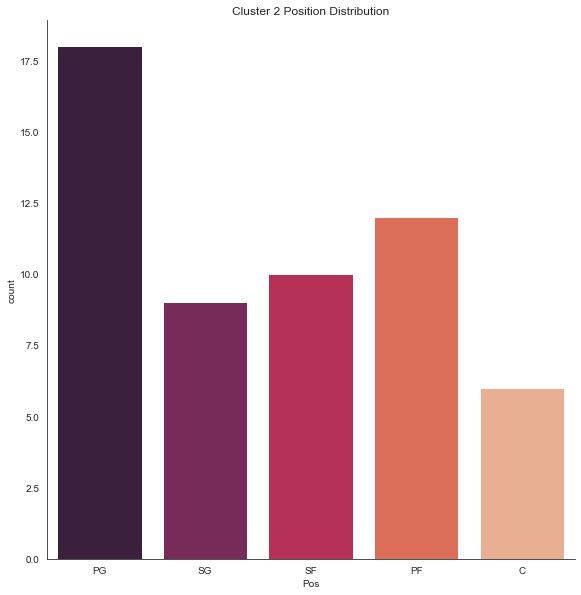

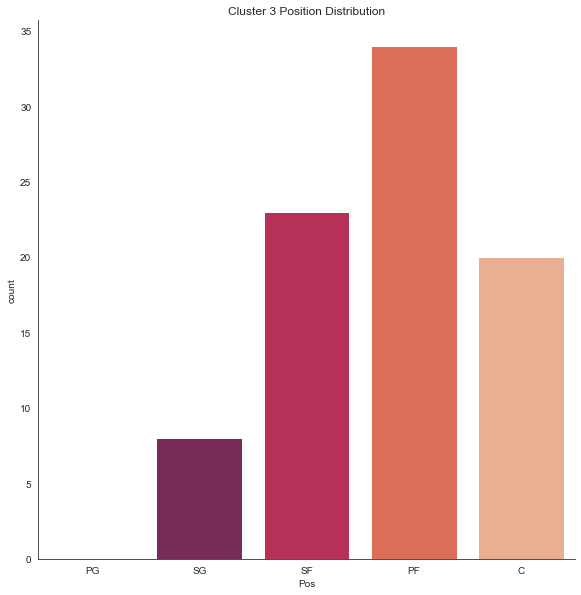

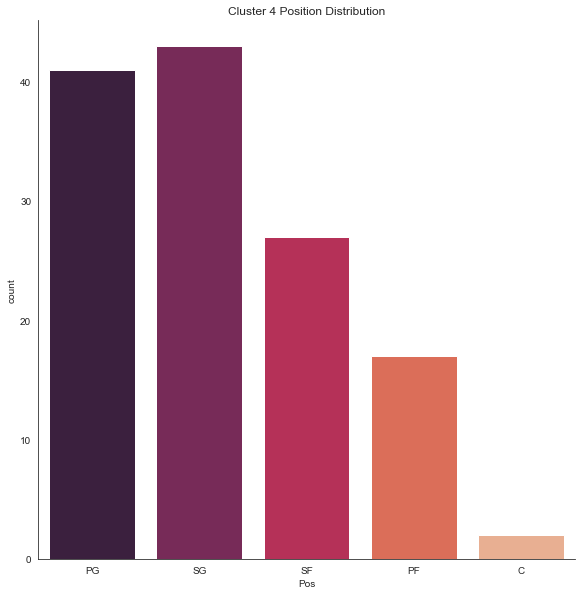

In [18]:
for cluster in range(0,5):
    
    temp = nba[nba['cluster'] == cluster].reset_index()
    
    sns.catplot(data=temp, x="Pos", kind="count", 
                palette='rocket', order=['PG', 'SG', 'SF', 'PF', 'C'], height=8)
    plt.title(f"Cluster {cluster} Position Distribution")
    plt.show()
    print('\n\n')

Cluster 2, our best players, have a decent spread of positional players. In fact, almost every cluster has a moderate spread of positions. This speaks to our larger point, that basketball greatness and listed position have little relation to one another.

Lastly, we'll dig in to a few stats to see how they differ between clusters

In [19]:
for cluster in range(0,5):
    
    temp = nba[nba['cluster'] == cluster].reset_index()
    
    print(f'---- Cluster {cluster}\n')
    
    print(f'Points:\t\t\t{temp["PTS"].mean()}')
    print(f'Effective FG%:\t\t{temp["eFG%"].mean()}')
    print(f'Steals:\t\t\t{temp["STL"].mean()}')
    print(f'Blocks:\t\t\t{temp["BLK"].mean()}')
    print(f'Assists:\t\t{temp["AST"].mean()}')
    print(f'Total rebounds:\t\t{temp["TRB"].mean()}')
    print('\n\n')

---- Cluster 0

Points:			11.7421568627451
Effective FG%:		0.5369754901960785
Steals:			0.8467864923747277
Blocks:			0.3854030501089325
Assists:		2.678376906318083
Total rebounds:		3.7710239651416115



---- Cluster 1

Points:			9.334920634920637
Effective FG%:		0.6094920634920634
Steals:			0.6005291005291004
Blocks:			1.0629629629629629
Assists:		1.2761904761904763
Total rebounds:		6.768253968253969



---- Cluster 2

Points:			21.879393939393943
Effective FG%:		0.5524969696969697
Steals:			1.141818181818182
Blocks:			0.5690909090909091
Assists:		5.581212121212122
Total rebounds:		6.512727272727273



---- Cluster 3

Points:			5.881176470588236
Effective FG%:		0.5141019607843137
Steals:			0.4402941176470589
Blocks:			0.4550980392156863
Assists:		1.0040196078431374
Total rebounds:		3.4995098039215677



---- Cluster 4

Points:			5.022115384615384
Effective FG%:		0.4623344266331108
Steals:			0.45211538461538464
Blocks:			0.16756410256410256
Assists:		1.355
Total rebounds:		1.96083333333

While we've already identified Cluster 2 as our best players, Cluster 0 players seem to be the best role-players. They score consistently, dish out assists, and shoot at a respectable 53.6 effective field goal %

----------

## Playoffs or Bust

In this final section, we'll see how playoff and non-playoff teams are constructed differently

In [20]:
# Top and bottom two teams from each conference
playoff_teams = ['UTA', 'PHO', 'PHI', 'BRK']
lottery_teams = ['HOU', 'OKC', 'DET', 'ORL']

all_teams = playoff_teams + lottery_teams

In [21]:
# Isolate players from the above teams
playoff_or_bust = nba[nba['Tm'].isin(all_teams)].reset_index(drop=True)

playoff_or_bust.head()

,Player,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Pos,Tm,cluster
0,Joel Embiid,26.0,51.0,51.0,31.1,9.0,17.6,0.513,1.1,3.0,...,3.2,8.8,0.266,6.3,1.2,7.5,3.8,C,PHI,2
1,Kyrie Irving,28.0,54.0,54.0,34.9,10.2,20.1,0.506,2.8,7.0,...,1.6,7.4,0.189,5.7,-0.2,5.5,3.6,PG,BRK,2
2,Kevin Durant,32.0,35.0,32.0,33.1,9.3,17.2,0.537,2.4,5.4,...,1.2,5.0,0.206,6.4,0.8,7.2,2.7,PF,BRK,2
3,Donovan Mitchell,24.0,53.0,53.0,33.4,9.0,20.6,0.438,3.4,8.7,...,2.2,6.2,0.167,4.6,-0.2,4.3,2.8,PG,UTA,2
4,Devin Booker,24.0,67.0,67.0,33.9,9.3,19.2,0.484,1.9,5.5,...,2.0,4.9,0.104,1.7,-1.4,0.3,1.3,SG,PHO,2


In [22]:
# Binarize playoff status
def made_the_playoffs(x):
    if x in playoff_teams:
        return 1
    else:
        return 0
    
# Create new playoff status variable   
playoff_or_bust['playoff-status'] = playoff_or_bust['Tm'].apply(lambda x: made_the_playoffs(x))
playoff_or_bust['cluster'] = playoff_or_bust['cluster'].astype(str)

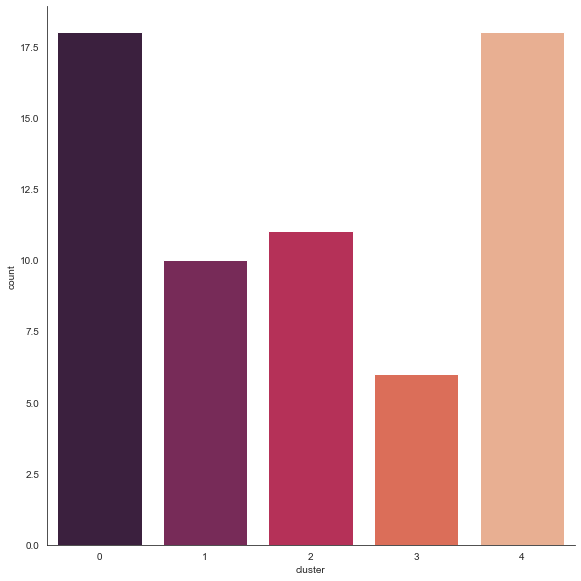

In [23]:
sns.catplot(data=playoff_or_bust[playoff_or_bust['playoff-status'] == 1],
            x='cluster', kind='count', height=8, order=['0','1','2','3','4'],
           palette='rocket')
plt.show()

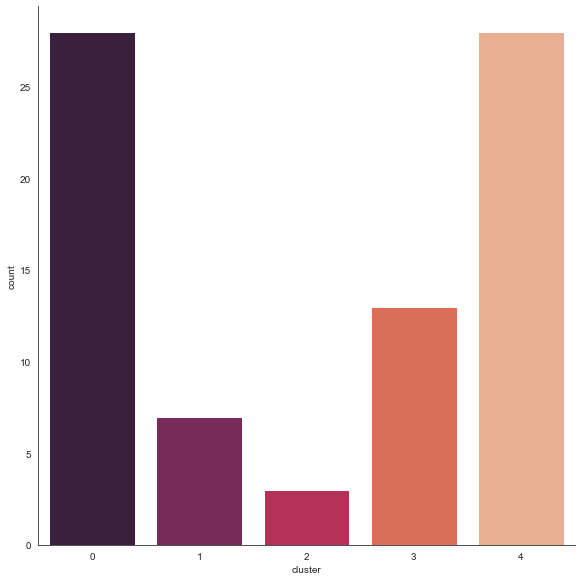

In [24]:
sns.catplot(data=playoff_or_bust[playoff_or_bust['playoff-status'] == 0],
            x='cluster', kind='count', height=8, order=['0','1','2','3','4'],
           palette='rocket')
plt.show()

Predictably, teams that didn't make the playoffs had significantly fewer Cluster 2 players than teams that did. Indeed, the total number of Cluster 0 players (our steadfast #2 players) is greater in the non-playoff pool ... perhaps teams that don't make the playoffs have a #2 player slotted in as a #1

---------